<font size="5">
 <div class="alert alert-block alert-info"><b>Master in Data Science - Iscte <b>
     </div>
</font>   
    
<font size="5"> OEOD </font>

<font size="3"> Afonso Fareleiro - Armando Ferreira - Tomás Carvalho </font>
  
<font size="3"> Group 12 - 'MU' Micron Technology, Inc 

# RL for algorithmic trading

In [1]:
# Import libraries

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym

# High-quality figures
%config InlineBackend.figure_format = 'svg'

## 1. Obtain/Extract the historical stock prices

In [2]:
# Historical stock price data for MU, from the period 2019 to 2023
## 'MU - Micron Technology, Inc' is an US based semiconductor company

mu = yf.Ticker("MU")
data = mu.history(start="2019-01-01", end="2023-09-30")

data.info()
data.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1195 entries, 2019-01-02 00:00:00-05:00 to 2023-09-29 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1195 non-null   float64
 1   High          1195 non-null   float64
 2   Low           1195 non-null   float64
 3   Close         1195 non-null   float64
 4   Volume        1195 non-null   int64  
 5   Dividends     1195 non-null   float64
 6   Stock Splits  1195 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 74.7 KB


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-09-25 00:00:00-04:00,68.176264,69.074767,67.497396,68.465782,14900000,0.0,0.0
2023-09-26 00:00:00-04:00,67.856800,68.935003,67.477428,67.826851,12752500,0.0,0.0
2023-09-27 00:00:00-04:00,68.006551,68.735331,66.638830,68.096397,20852300,0.0,0.0
2023-09-28 00:00:00-04:00,65.860130,66.978259,63.723694,65.091408,46749800,0.0,0.0
2023-09-29 00:00:00-04:00,66.249478,68.615533,66.249478,67.916695,24307500,0.0,0.0


<Axes: xlabel='Date'>

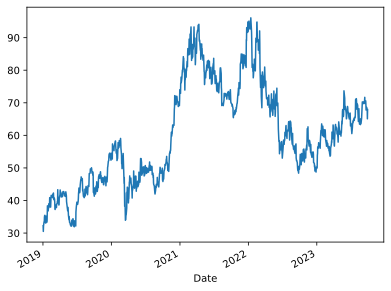

In [3]:
# Daily close price data for MU
data.Close.plot()

## 2. Calculate returns, expected mean returns and risk

In [4]:
# Asset Returns/Rate of Returns: the cumulative daily rate of return is useful to determine /
#                                   the value of an investment at regular intervals.
data_close = data[['Close']]
data_close.columns = ['MU']

returns = np.log(data_close / data_close.shift(1))
returns = returns.dropna()

# Expected Mean Returns
mean_returns = returns.mean()

# Volatility: market volatility is defined as the standard deviation of prices/returns.
vol = returns.std()

# Gain-Loss Ratio (GLR) represents the relative relationship of trades with a positive /
#                                       return and trades with a negative return
glr = returns[returns['MU'] > 0].sum() / returns[returns['MU'] < 0].sum().abs()

# Sharpe Ratio (SR) is the amount of excess return over the risk-free rate as the relevant measure of risk.
## rf is daily risk free rate.
# rf = (1.02 ** (1 / 360)) - 1

risk_free_rate = 0
sr = (mean_returns - risk_free_rate) / vol

# Compound Annual Growth Rate (CAGR)
cumulative_returns = returns.cumsum()
num_trading_days = len(returns)
cagr = (cumulative_returns['MU'][-1]) ** (252/num_trading_days) - 1

# Variance
var = returns.var() * 252

# CVAR
cvar = returns[returns <= np.percentile(returns, 5)].mean() * 252

# See metrics in table format
data_summary = pd.DataFrame({
    'Mean Returns': mean_returns,
    'Volatility': vol,
    'Gain-Loss Ratio (GLR)': glr,
    'Sharpe Ratio (SR)': sr,
    'CAGR': cagr,
    'Variance': var,
    'CVAR': cvar
})

data_summary


,Mean Returns,Volatility,Gain-Loss Ratio (GLR),Sharpe Ratio (SR),CAGR,Variance,CVAR
MU,0.000624,0.029188,1.059818,0.02138,-0.060209,0.214685,-16.058258


## 3. Define statistical trading strategy (at least one, maximum 2)

In [5]:
# Exponential moving average (EMA) strategy
def ema_strategy(data):
    # Define your trading strategy based on the historical data
    # Example: Buy when the 20-day moving average is above the 100-day moving average, sell otherwise
    signals = pd.DataFrame(data)

    # EMA for 10 and 50-day windows
    signals['ema_short'] = signals['Close'].ewm(span = 20, adjust = False).mean()
    signals['ema_long'] = signals['Close'].ewm(span = 100, adjust = False).mean()
                         
    # Define a crossover strategy
    signals['bullish'] = 0.0
    signals['bullish'] = np.where(signals['ema_short'] > signals['ema_long'], 1, -1)
    signals['crossover'] = signals['bullish'].diff()

    # Calculate passive and strategy's returns
    signals['returns'] = np.log(signals['Close'] / signals['Close'].shift(1))
    signals['strategy'] = signals['bullish'].shift(1) * signals['returns']
    
    return signals

C:\Users\Admin\AppData\Local\Temp\ipykernel_16372\40032159.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(ema['ema_long'][idx], 'ro', markersize = 5, color='#6a994e')


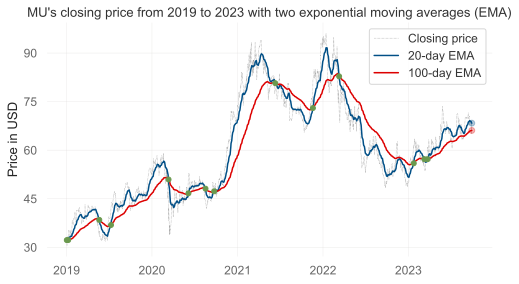

In [22]:
# Initiate strategy
ema = ema_strategy(data)

# Plot exponential moving averages for our strategy
# fig, ax = plt.subplots(figsize=(13.33,7.5), dpi = 96)
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(ema['Close'], label='Closing price', color='grey', linestyle=':', linewidth=0.5)
ax.plot(ema['ema_short'], label='20-day EMA', color='#014f86')
ax.plot(ema.index[-1], ema['ema_short'].iloc[-1], 'o', markersize=6, alpha=0.3, color='#014f86')
ax.plot(ema['ema_long'], label='100-day EMA', color='#DC0000')
ax.plot(ema.index[-1], ema['ema_long'].iloc[-1], 'o', markersize=6, alpha=0.3, color='#DC0000')


# Plot crossovers
idx = np.argwhere(ema['crossover']).flatten()
ax.plot(ema['ema_long'][idx], 'ro', markersize = 5, color='#6a994e')

# Add Legend and Labels
ax.legend(loc='best')

# Prettify

## Create the grid 
ax.grid(which="major", axis='x', color='#DAD8D7', alpha=0.5, zorder=1)
ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)

## Reformat y-axis
ax.set_ylabel('Price in USD')
ax.yaxis.set_major_locator(plt.MaxNLocator(5))

## Remove the spines
ax.spines[['top','right','bottom']].set_visible(False)

## Make the left spine thicker
ax.spines['left'].set_linewidth(1.1)
# Add in title and subtitle
ax.set_title(label="MU's closing price from 2019 to 2023 with two exponential moving averages (EMA)")
## Adjust the margins around the plot area
plt.subplots_adjust(left=None, bottom=0.2, right=None, top=0.85, wspace=None, hspace=None)

# Show the plot
plt.show()


<Axes: title={'center': 'Strategy Positioning'}, xlabel='Date'>

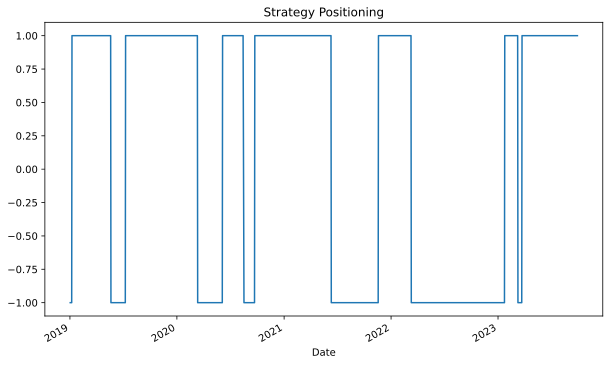

In [7]:
# Plot our strategy's positions
ema['bullish'].plot(ylim=[-1.1, 1.1],
title='Strategy Positioning',
figsize=(10, 6))

returns     187.767570
strategy   -128.189729
dtype: float64

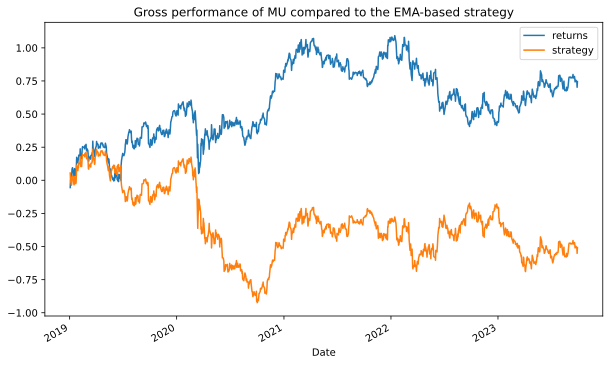

In [8]:
# Plot our strategy's returns compared to MU's stock performance
ema[['returns', 'strategy']].cumsum().plot(figsize=(10, 6), 
                                                         title="Gross performance of MU compared to the EMA-based strategy")

ema[['returns', 'strategy']].sum() * 252

## 4. Evaluate the efficacy of the trading strategy

In [9]:
'''Falta calcular métricas para a estratégia estatistica'''

'Falta calcular métricas para a estratégia estatistica'

## 5. Use at least one reinforcement learning algorithm for trading the assets (Q-learning, deep Q-learning)

In [10]:
# create environment with specific parameters
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL
mu = yf.Ticker("MU")
data = mu.history(start="2019-01-01", end="2023-09-30")


env = gym.make('forex-v0',
    df = data,
    window_size=5,
    #frame_bound=(50, 100),
    unit_side='right'
)

In [11]:
# print information
print("env information:")
print("> shape:", env.unwrapped.shape)
print("> df.shape:", env.unwrapped.df.shape)
print("> prices.shape:", env.unwrapped.prices.shape)
print("> signal_features.shape:", env.unwrapped.signal_features.shape)
print("> max_possible_profit:", env.unwrapped.max_possible_profit())

env information:
> shape: (5, 2)
> df.shape: (1195, 7)
> prices.shape: (1176,)
> signal_features.shape: (1176, 2)
> max_possible_profit: 355528.1811673705


info: {'total_reward': -449167.25158691406, 'total_profit': 0.9436550350419758, 'position': <Positions.Long: 1>}


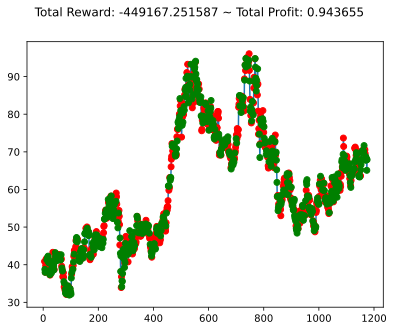

In [12]:
observation = env.reset(seed=2023)
while True:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # env.render()
    if done:
        print("info:", info)
        break

plt.cla()
env.unwrapped.render_all()
plt.show()

## 6. Evaluate the efficacy of the RL trading strategy

                           Strategy
-------------------------  ----------
Start Period               2019-01-03
End Period                 2023-08-24
Risk-Free Rate             0.0%
Time in Market             25.0%

Cumulative Return          -5.63%
CAGR﹪                     -0.86%

Sharpe                     0.13
Prob. Sharpe Ratio         60.96%
Smart Sharpe               0.13
Sortino                    0.18
Smart Sortino              0.18
Sortino/√2                 0.13
Smart Sortino/√2           0.13
Omega                      1.05

Max Drawdown               -58.01%
Longest DD Days            931
Volatility (ann.)          32.63%
Calmar                     -0.01
Skew                       -1.62
Kurtosis                   45.38

Expected Daily %           -0.0%
Expected Monthly %         -0.1%
Expected Yearly %          -1.15%
Kelly Criterion            2.44%
Risk of Ruin               0.0%
Daily Value-at-Risk        -3.36%
Expected Shortfall (cVaR)  -3.36%

Max Consecutive Wins   

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-02-05,2022-11-21,2023-08-24,930,-58.010737,-57.095061
2,2020-01-27,2020-02-07,2020-05-11,105,-31.659368,-19.051719
3,2019-01-04,2019-04-25,2019-05-23,139,-23.466932,-21.799891
4,2019-08-15,2019-09-13,2019-11-29,107,-17.653941,-13.978633
5,2020-05-18,2020-07-17,2020-12-07,204,-16.160050,-14.247337


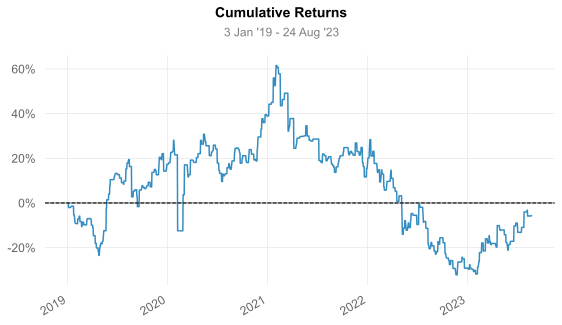

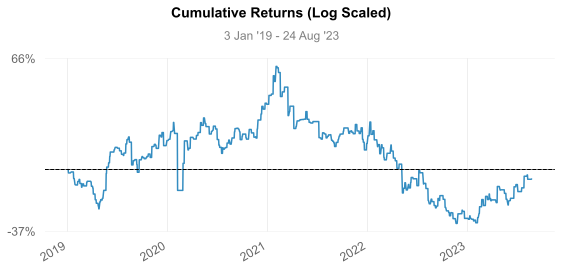

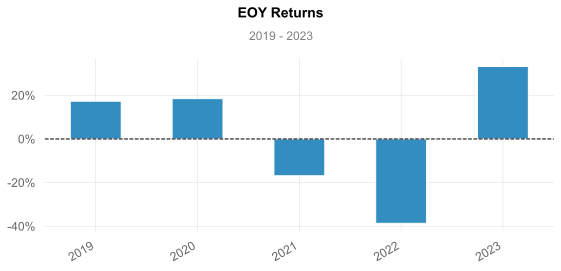

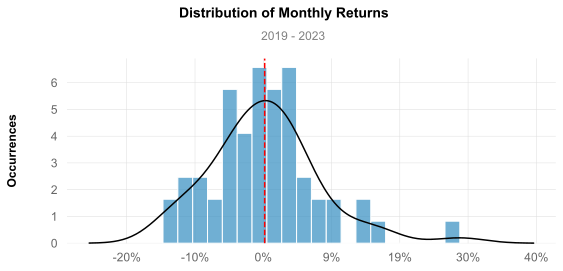

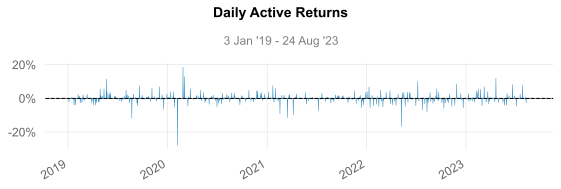

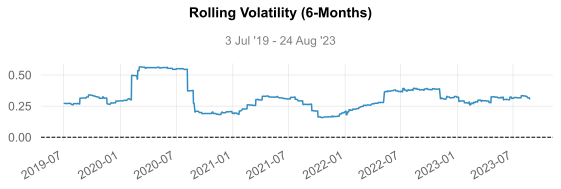

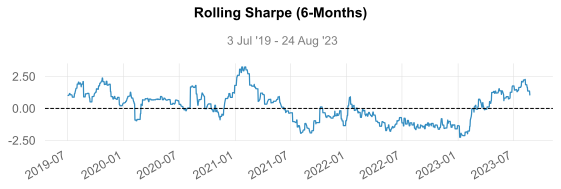

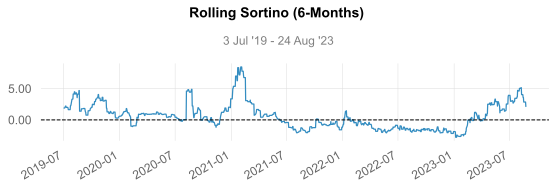

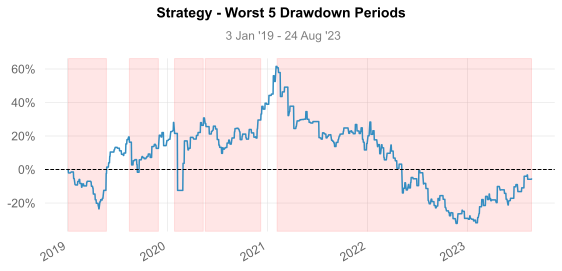

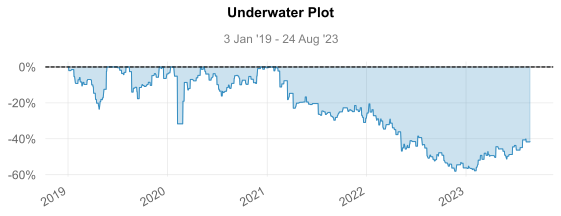

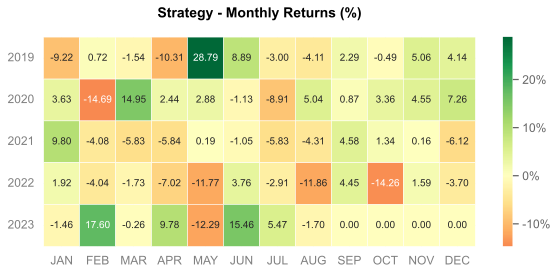

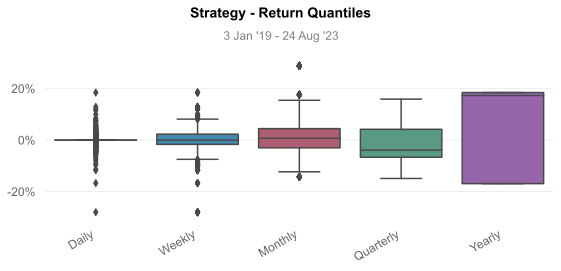

In [13]:
# from stable_baselines3 import A2C

import quantstats as qs
import pandas as pd

qs.extend_pandas()

net_worth = pd.Series(env.unwrapped.history['total_profit'], index=data.index[0:1170])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)
# qs.reports.html(returns, output='SB3_a2c_quantstats.html')

## 7. Fine-tune your algorithms

In [14]:
'''Insert code here'''

'Insert code here'

## 8. Compare and interpret the results

In [15]:
'''Insert code here'''

'Insert code here'